In [3]:
!ls /net/scratch2/siyangwu/tinibench/experiment1:wiki_ppl

gemma-3-4b-it.csv
Llama-3.2-3B-Instruct.csv
Phi-3-mini-4k-instruct.csv
phi-4.csv
Qwen3-0.6B.csv
Qwen3-8B.csv
wiki-filtered_gemma-3-4b-it.parquet
wiki-filtered_gpt2.parquet
wiki-filtered_Llama-3.2-3B-Instruct.parquet
wiki-filtered_Llama-3.2-3B.parquet
wiki-filtered_Phi-3-mini-4k-instruct.parquet
wiki-filtered_phi4.parquet
wiki-filtered_Qwen3-0.6B.parquet
wiki-filtered_Qwen3-8B.parquet


In [1]:
import pandas as pd 
import numpy as np
# incommon 
# common_models = [
#     "gemma-3-4b-it",
#     "Llama-3.2-3B-Instruct",
#     "Phi-3-mini-4k-instruct",
#     "phi4",
#     "Qwen3-0.6B",
#     "Qwen3-8B"
# ]



In [1]:
import pandas as pd
import numpy as np
import os
import math

# Define the folder and files
base_path = "/net/scratch2/siyangwu/tinibench/experiment1:wiki_ppl"
parquet_files = {
    "gemma-3-4b-it": "wiki-filtered_gemma-3-4b-it.parquet",
    "Llama-3.2-3B-Instruct": "wiki-filtered_Llama-3.2-3B-Instruct.parquet",
    "Phi-3-mini-4k-instruct": "wiki-filtered_Phi-3-mini-4k-instruct.parquet",
    "phi-4": "wiki-filtered_phi4.parquet",
    "Qwen3-0.6B": "wiki-filtered_Qwen3-0.6B.parquet",
    "Qwen3-8B": "wiki-filtered_Qwen3-8B.parquet"
}

# Function to compute perplexity from logprobs
def compute_perplexities(df):
    df_ppl = pd.DataFrame()
    for col in df.columns:
        if "logprob" in col:
            avg_logprob = df[col].apply(np.mean)
            ppl = np.exp(-avg_logprob)
            df_ppl[col] = ppl
    return df_ppl

# Process each file and compute token-level perplexities
all_ppl = []

for model_name, file_name in parquet_files.items():
    full_path = os.path.join(base_path, file_name)
    df = pd.read_parquet(full_path)
    df_ppl = compute_perplexities(df)
    df_ppl.columns = [f"{model_name}" for _ in df_ppl.columns]  # unify model name
    all_ppl.append(df_ppl.mean(axis=1))  # average if multiple logprob columns per model

# Combine all perplexity columns into one DataFrame
ppl_df = pd.concat(all_ppl, axis=1)
ppl_df.columns = list(parquet_files.keys())

In [2]:
ppl_df.head()

,gemma-3-4b-it,Llama-3.2-3B-Instruct,Phi-3-mini-4k-instruct,phi-4,Qwen3-0.6B,Qwen3-8B
0,44.263416,3.994125,2.570821,3.217636,11.027039,4.287660
1,142.279068,8.019073,4.304696,3.918892,20.584625,7.036053
2,87.107178,8.294314,4.445204,5.220045,23.575470,9.456997
3,125.225395,6.731973,4.797678,4.633311,11.950290,4.922348
4,51.996536,7.785151,3.243001,5.196146,10.616940,7.689096


In [3]:
performance = pd.read_csv("/net/scratch2/siyangwu/tinibench/experiment1:wiki_ppl/gemma-3-4b-it.csv")
performance.head()

,question_id,predicted_letter,correct_letter,is_correct,model_response
0,Q0,C,C,True,C
1,Q1,C,C,True,C
2,Q1002,C,C,True,C
3,Q1003,C,A,False,Answer: C
4,Q1007,C,T,False,C


In [4]:
import pandas as pd
import os

# Base path and files
csv_base_path = "/net/scratch2/siyangwu/tinibench/experiment1:wiki_ppl"
csv_files = [
    "gemma-3-4b-it.csv",
    "Llama-3.2-3B-Instruct.csv",
    "Phi-3-mini-4k-instruct.csv",
    "phi-4.csv",
    "Qwen3-0.6B.csv",
    "Qwen3-8B.csv"
]

# Dictionary to hold model accuracies
model_accuracy = {}

# Process each CSV file
for file in csv_files:
    model_name = file.replace(".csv", "")
    file_path = os.path.join(csv_base_path, file)
    df = pd.read_csv(file_path)
    
    # Filter out empty responses
    df_filtered = df[df["model_response"].notna() & (df["model_response"].str.strip() != "")]
    
    # Compute accuracy
    if "is_correct" in df_filtered.columns:
        accuracy = df_filtered["is_correct"].mean()
        model_accuracy[model_name] = accuracy
    else:
        model_accuracy[model_name] = None  # missing correctness info

model_accuracy


{'gemma-3-4b-it': np.float64(0.6583034647550776),
 'Llama-3.2-3B-Instruct': np.float64(0.3954599761051374),
 'Phi-3-mini-4k-instruct': np.float64(0.5256869772998806),
 'phi-4': np.float64(0.4405594405594406),
 'Qwen3-0.6B': np.float64(0.2855436081242533),
 'Qwen3-8B': np.float64(0.46236559139784944)}

In [5]:
ppl_df.columns

Index(['gemma-3-4b-it', 'Llama-3.2-3B-Instruct', 'Phi-3-mini-4k-instruct',
       'phi-4', 'Qwen3-0.6B', 'Qwen3-8B'],
      dtype='object')

In [6]:
import numpy as np
import pandas as pd
import itertools

# ── Assume ppl_df and model_accuracy are loaded in your workspace ──────────────
#    ppl_df: DataFrame of shape (n_chunks, d_models)
#    model_accuracy: dict mapping each model name to its accuracy

# 1) Align models present in both
common_models = sorted(set(ppl_df.columns).intersection(model_accuracy.keys()))

# 2) Build accuracy vector y
y = np.array([model_accuracy[m] for m in common_models])

# 3) Compute γ_j for each chunk j
gamma_values = []
for idx, row in ppl_df[common_models].iterrows():
    x = row.values  # perplexity of each model on chunk idx
    ranks = pd.Series(x).rank(method="average", ascending=True).values
    gamma = 0.0
    d = len(common_models)
    for k, l in itertools.permutations(range(d), 2):
        gamma += np.sign(y[k] - y[l]) * (ranks[k] - ranks[l])
    gamma_values.append(gamma)

# 4) Create and display results
result_df = pd.DataFrame({
    "chunk_index": ppl_df.index,
    "gamma": gamma_values
})


In [7]:
import pandas as pd
top20_indices = result_df.nlargest(20, "gamma")["chunk_index"].tolist()
# 1) Load the chunk‐text DataFrame
texts_df = pd.read_parquet("data/filtered_chunked_texts_df.parquet")

# 2) Inspect its structure
print("Index name/type:", texts_df.index.name, type(texts_df.index))
print("First few index values:", texts_df.index[:5])
print("Columns:", list(texts_df.columns))

# 3) Assume the actual text column is named "text"
#    And select by *position* rather than label
top20_positions = top20_indices  # your list of integer positions

top_chunks = (
    texts_df
    .reset_index(drop=False)      # move the old index into a column
    .iloc[top20_positions]        # pick by integer position
    [[texts_df.index.name or "index", "chunk_text"]]  # keep original index col + text
    .rename(columns={texts_df.index.name or "index": "chunk_index"})
)

print(top_chunks)


Index name/type: None <class 'pandas.core.indexes.base.Index'>
First few index values: Index([360, 361, 362, 363, 364], dtype='int64')
Columns: ['text_id', 'chunk_id', 'chunk_text']
       chunk_index                                         chunk_text
23673        54862  An expedition by the Sultan of Tidore, togethe...
23778        54967  in the South West Pacific Theatre of World War...
24773        57774  within the United States, although rare errors...
24907        57908  Bob Clendenin as Tom Gazelian (recurring in se...
24986        57987  and a red light warning for everything that is...
25312        58619  2022, Yung Bleu released his single "Love in t...
25522        58933  she did it without support from outside groups...
25523        58934  the entire four days calling and emailing ever...
28679        65897  tradition that if the weather was sunny and cl...
29199        67234  interests\nMcCreery is an avid sports fan and ...
29472        67628  Guns N' Roses, Elizabeth Tay

In [8]:
# Assuming you already have `top_chunks` DataFrame with columns ["chunk_index", "text"] in your workspace:

output_path = "top20_chunks.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for _, row in top_chunks.iterrows():
        f.write(f"=== Chunk {row['chunk_index']} ===\n")
        f.write(row['chunk_text'].strip() + "\n\n")

print(f"Saved top 20 chunks to {output_path}")


Saved top 20 chunks to top20_chunks.txt


# top 100

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

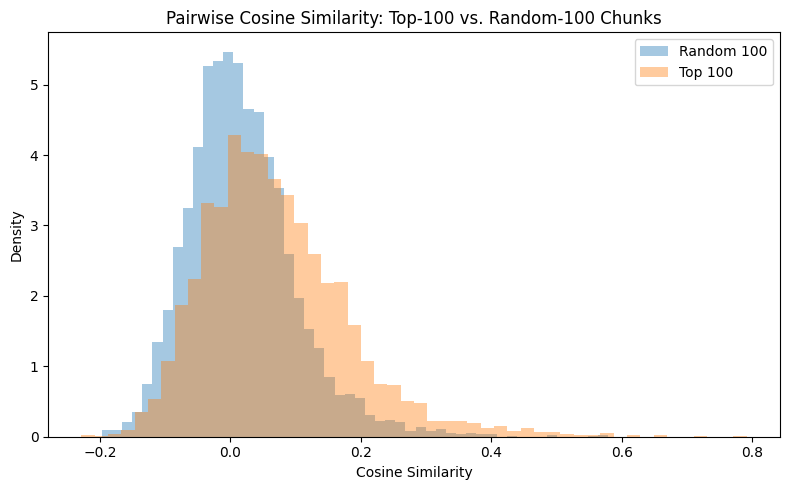

In [13]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ── 1) Load your data ────────────────────────────────────────────────
# Chunk‐level γ scores (must have columns ["chunk_index","gamma"])


# Chunk texts
texts_df = pd.read_parquet("data/filtered_chunked_texts_df.parquet")

# Figure out which column holds the text
if "chunk_text" in texts_df.columns:
    text_col = "chunk_text"
elif "text" in texts_df.columns:
    text_col = "text"
else:
    raise ValueError(f"Could not find chunk text column among {texts_df.columns.tolist()}")

# ── 2) Select top 100 and 100 random chunks ────────────────────────────
# chunk_index in result_df refers to the integer position in texts_df
top100_idx = result_df.nlargest(100, "gamma")["chunk_index"].astype(int).tolist()

# All valid positions 0…len(texts_df)-1
all_pos = np.arange(len(texts_df))
# Exclude top100, then sample 100
random100_pos = np.random.choice(np.setdiff1d(all_pos, top100_idx), 100, replace=False)

# Reset index so that original integer positions become a column
texts_reset = texts_df.reset_index(drop=False)
orig_idx_col = texts_reset.columns[0]  # usually "index" or whatever your index name was

# Extract the actual texts
top100_texts  = texts_reset.iloc[top100_idx][text_col].tolist()
rand100_texts = texts_reset.iloc[random100_pos][text_col].tolist()

# ── 3) Embed both sets ───────────────────────────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
emb_top  = model.encode(top100_texts,  convert_to_numpy=True, show_progress_bar=True)
emb_rand = model.encode(rand100_texts, convert_to_numpy=True, show_progress_bar=True)

# ── 4) Compute pairwise cosine similarities (i<j) ────────────────────
def pairwise_upper_sims(emb):
    sims = cosine_similarity(emb)
    i, j = np.triu_indices_from(sims, k=1)
    return sims[i, j]

sims_top  = pairwise_upper_sims(emb_top)
sims_rand = pairwise_upper_sims(emb_rand)

# ── 5) Plot distributions ────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.hist(sims_rand, bins=50, alpha=0.4, label="Random 100", density=True)
plt.hist(sims_top,  bins=50, alpha=0.4, label="Top 100",    density=True)
plt.title("Pairwise Cosine Similarity: Top-100 vs. Random-100 Chunks")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



# lowest 100

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

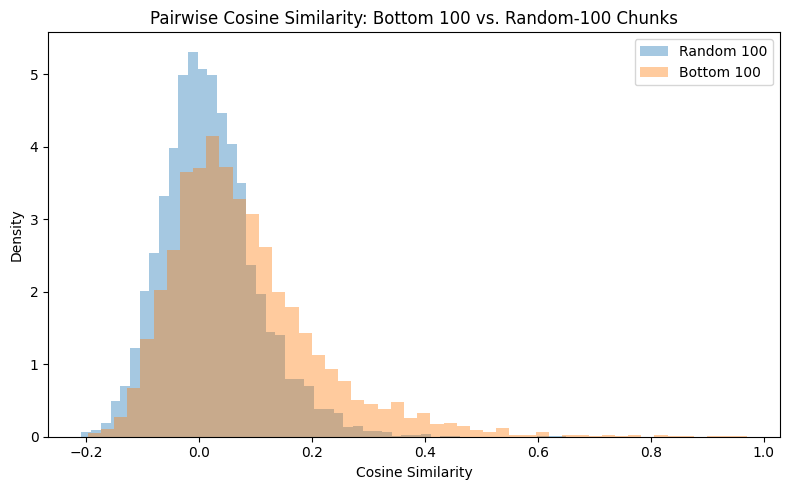

In [10]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ── 1) Load your data ────────────────────────────────────────────────
# Chunk‐level γ scores (must have columns ["chunk_index","gamma"])


# Chunk texts
texts_df = pd.read_parquet("data/filtered_chunked_texts_df.parquet")

# Figure out which column holds the text
if "chunk_text" in texts_df.columns:
    text_col = "chunk_text"
elif "text" in texts_df.columns:
    text_col = "text"
else:
    raise ValueError(f"Could not find chunk text column among {texts_df.columns.tolist()}")

# ── 2) Select top 100 and 100 random chunks ────────────────────────────
# chunk_index in result_df refers to the integer position in texts_df
bottom100_idx = result_df.nsmallest(100, "gamma")["chunk_index"].astype(int).tolist()


# All valid positions 0…len(texts_df)-1
all_pos = np.arange(len(texts_df))
# Exclude top100, then sample 100
random100_pos = np.random.choice(np.setdiff1d(all_pos, bottom100_idx), 100, replace=False)

# Reset index so that original integer positions become a column
texts_reset = texts_df.reset_index(drop=False)
orig_idx_col = texts_reset.columns[0]  # usually "index" or whatever your index name was

# Extract the actual texts
top100_texts  = texts_reset.iloc[bottom100_idx][text_col].tolist()
rand100_texts = texts_reset.iloc[random100_pos][text_col].tolist()

# ── 3) Embed both sets ───────────────────────────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
emb_top  = model.encode(top100_texts,  convert_to_numpy=True, show_progress_bar=True)
emb_rand = model.encode(rand100_texts, convert_to_numpy=True, show_progress_bar=True)

# ── 4) Compute pairwise cosine similarities (i<j) ────────────────────
def pairwise_upper_sims(emb):
    sims = cosine_similarity(emb)
    i, j = np.triu_indices_from(sims, k=1)
    return sims[i, j]

sims_top  = pairwise_upper_sims(emb_top)
sims_rand = pairwise_upper_sims(emb_rand)

# ── 5) Plot distributions ────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.hist(sims_rand, bins=50, alpha=0.4, label="Random 100", density=True)
plt.hist(sims_top,  bins=50, alpha=0.4, label="Bottom 100",    density=True)
plt.title("Pairwise Cosine Similarity: Bottom 100 vs. Random-100 Chunks")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



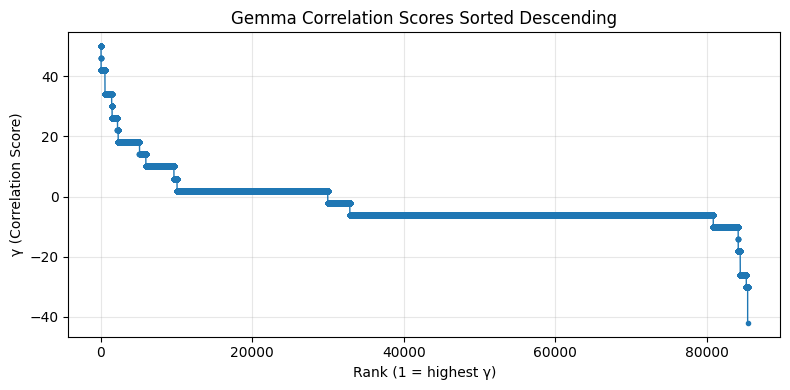

In [14]:
sorted_df = result_df.head(100000000).sort_values("gamma", ascending=False).reset_index(drop=True)

# Plot sorted gamma values
plt.figure(figsize=(8, 4))
plt.plot(sorted_df.index + 1, sorted_df["gamma"], marker=".", linewidth=1)
plt.xlabel("Rank (1 = highest γ)")
plt.ylabel("γ (Correlation Score)")
plt.title("Gemma Correlation Scores Sorted Descending")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error



loo = LeaveOneOut()
lasso_pipe = make_pipeline(
    StandardScaler(with_mean=False),
    LassoCV(alphas=np.logspace(-4, 2, 50),
            cv=LeaveOneOut(),
            max_iter=10_000)
)

# ── leave-one-out loop (row slices via .iloc) ───────────────────────────────
preds = np.empty_like(y, dtype=float)
for train_idx, test_idx in loo.split(X):
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_train = y[train_idx]
    lasso_pipe.fit(X_train, y_train)
    preds[test_idx] = lasso_pipe.predict(X_test)

R2  = r2_score(y, preds)
MSE = mean_squared_error(y, preds)

print(f"LOO R²  = {R2:+.3f}")
print(f"LOO MSE = {MSE:.4f}")

# ── fit once on all 6 rows to inspect sparsity pattern ──────────────────────
lasso_pipe.fit(X, y)
alpha = lasso_pipe.named_steps["lassocv"].alpha_
coefs = lasso_pipe.named_steps["lassocv"].coef_

print(f"\nα chosen by LassoCV = {alpha:.4g}")
print("Non-zero coefficients (chunk_id → β):")
for cid, beta in zip(X.columns, coefs):
    if beta != 0.0:
        print(f"  {cid:>6} → {beta:+.4f}")

LOO R²  = -0.525
LOO MSE = 0.0200

α chosen by LassoCV = 100
Non-zero coefficients (chunk_id → β):
